# Fundamentals of Machine Learning (CSCI-UA.473)
## Lab 8: t-SNE, Multi Dimensional Scaling, UMAP 

In [1]:
# Import the necessary packages from sci-kit learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
from sklearn.metrics import log_loss
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.utils import resample
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform #Import squareform, which creates a symmetric matrix from a vector
from umap import UMAP # run pip install umap-learn
# import seaborn as sns
import time
import math
import warnings
warnings.filterwarnings('ignore')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '0' ]

In [5]:
df = datasets.load_digits(as_frame=True)
X,y = df.data, df.target
print(X.shape, y.shape)

(1797, 64) (1797,)


In [3]:
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

PCA(n_components=2, whiten=True)

In [4]:
X_pca = pca.transform(X)

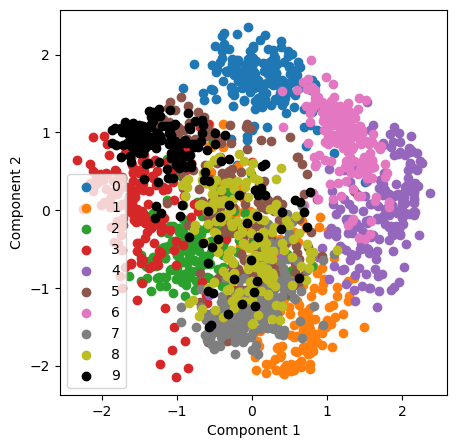

In [5]:
target_ids = range(len(df.target_names))
plt.figure(figsize=(5, 5))
for i, c, label in zip(target_ids, colors, df.target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], c=c, label=label)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [6]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit(X, y).transform(X)

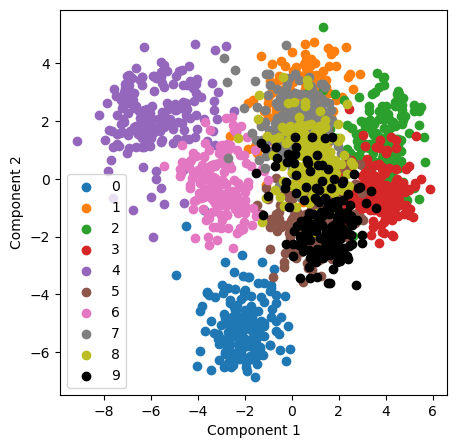

In [7]:
plt.figure(figsize=(5, 5))
for i, c, label in zip(target_ids, colors, df.target_names):
    plt.scatter(X_lda[y==i, 0], X_lda[y==i, 1], c=c, label=label)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

## Multi-Dimensional Scaling 

In [14]:
mds = MDS(n_components=2, metric=True, normalized_stress='auto', dissimilarity='euclidean')
X_mds = mds.fit_transform(X)

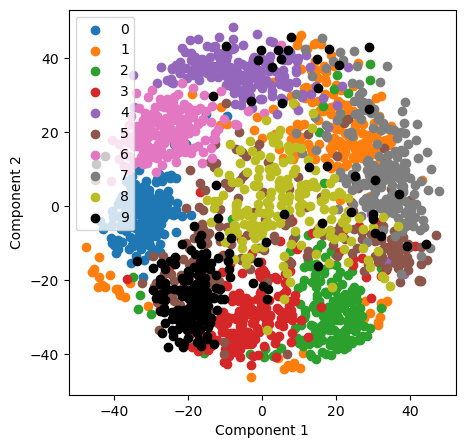

In [15]:
target_ids = range(len(df.target_names))
plt.figure(figsize=(5, 5))
for i, c, label in zip(target_ids, colors, df.target_names):
    plt.scatter(X_mds[y == i, 0], X_mds[y == i, 1], c=c, label=label)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

Let's load a custom dataset based on academic disciplines.

In [16]:
data = np.genfromtxt('fieldsMDS.csv',delimiter=',') # load file as data
print(data.shape)

(11, 11)


### Pre-processing the data for MDS
* Turn the matrix into a vector of pairwise distances
* Remove all nans to leave only pairwise distances remaining
* Create the distance matrix

In [17]:
dataVec = np.ndarray.flatten(data) 
dataVec = dataVec[~np.isnan(dataVec)] 
D = squareform(dataVec) 
fieldNames = ['Math', 'Physics', 'Chemistry', 'Biology', 'Psych', 'Neuro', 'Econ', 'Sociology', 'DS', 'CS']; #These are the academic fields

#### MDS Hyperparameters
n_components: Looking for a 2D solution, n_init: Number of runs with random initial starting positions, max_iter: Max number of iterations per run, dissimilarity: We already did it, from out distance matrix, 

In [18]:
mds = MDS(n_components=2, n_init=100, max_iter = 10000, dissimilarity='precomputed', normalized_stress='auto') #Create the mds object
mdsSolution = mds.fit_transform(D) #Actually run the mds

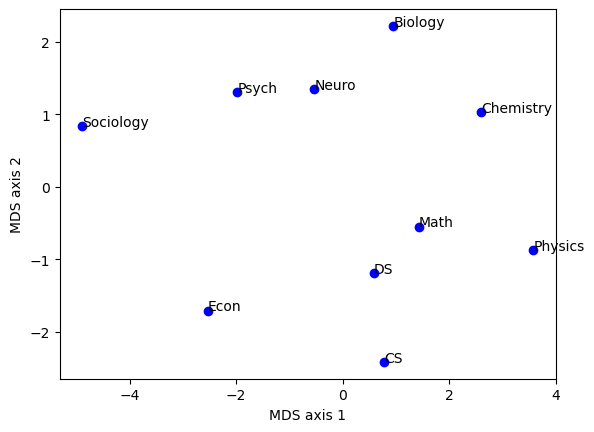

20.85972058635843


In [19]:
plt.scatter(mdsSolution[:,0], mdsSolution[:,1], color='blue') #Making the plot, first 2 dimensions
for ii in range(len(mdsSolution)):
    plt.text(mdsSolution[ii,0], mdsSolution[ii,1],fieldNames[ii])

plt.xlabel('MDS axis 1')
plt.ylabel('MDS axis 2')
plt.show()

print(mds.stress_) #How low could we get the stress? [Un-normalized]

## Loss measures when dealing with probabilities
When dealing with probabilistic values, we have typically used the log-loss or the cross-entropy loss. These are defined as : <br />
 $L_{\log}(y, p) = -(y \log (p) + (1 - y) \log (1 - p))$

In [20]:
y_true = [0, 0, 1, 1]
y_pred = [[.9, .1], [.8, .2], [.3, .7], [.01, .99]]
log_loss(y_true, y_pred)

0.1738073366910675

The Kullback-Leibler Divergence score, or KL divergence score, quantifies how much one probability distribution differs from another probability distribution. The intuition for the KL divergence score is that when the probability for an event from P is large, but the probability for the same event in Q is small, there is a large divergence. When the probability from P is small and the probability from Q is large, there is also a large divergence, but not as large as the first case.
It is given by : <br />

$$KL(P || Q) =  \sum_{x \in X} P(x) * \log(\frac{P(x)}{Q(x)})$$

P=1.000 Q=1.000


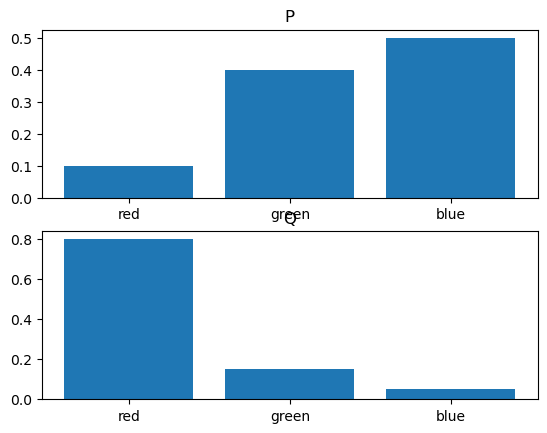

In [21]:
# define distributions
events = ['red', 'green', 'blue']
p = [0.10, 0.40, 0.50]
q = [0.80, 0.15, 0.05]

print('P=%.3f Q=%.3f' % (sum(p), sum(q)))
# plot first distribution
plt.subplot(2,1,1).set_title('P')
plt.bar(events, p)
# plot second distribution
plt.subplot(2,1,2).set_title('Q')
plt.bar(events, q)
# show the plot
plt.show()

In [22]:
# calculate the kl divergence
def kl_divergence(p, q):
    return sum(p[i] * math.log2(p[i]/q[i]) for i in range(len(p)))

In [23]:
# calculate (P || Q)
kl_pq = kl_divergence(p, q)
print('KL(P || Q): %.3f bits' % kl_pq)
# calculate (Q || P)
kl_qp = kl_divergence(q, p)
print('KL(Q || P): %.3f bits' % kl_qp)

KL(P || Q): 1.927 bits
KL(Q || P): 2.022 bits


## T-distributed Stochastic Neighbor Embedding (t-SNE) using scikit-learn
A statistical method for visualizing high-dimensional data by giving each datapoint a location in either a two or three-dimensional space which can be easily visualized using a scatter plot. It is not recommended for use in analysis such as clustering or outlier detection since it does not necessarily preserve densities or distances well.

In [36]:
X_embedded = TSNE(n_components=2, perplexity=50, n_jobs=-1).fit_transform(X)
X_embedded.shape

(1797, 2)

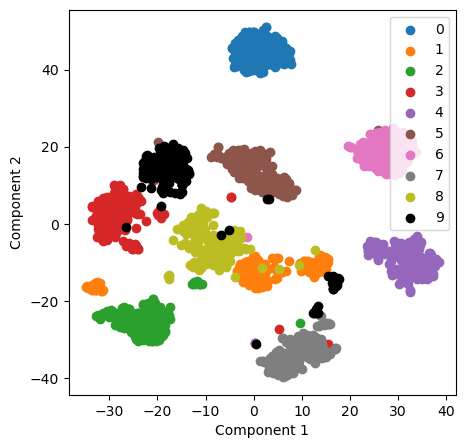

In [37]:
target_ids = range(len(df.target_names))
plt.figure(figsize=(5, 5))
for i, c, label in zip(target_ids, colors, df.target_names):
    plt.scatter(X_embedded[y == i, 0], X_embedded[y == i, 1], c=c, label=label)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

### Hyper-parameters for T-SNE [from sklearn documentation]
* Perplexity : Larger perplexities lead to more nearest neighbors and less sensitive to small structure. Conversely a lower perplexity considers a smaller number of neighbors, and thus ignores more global information in favour of the local neighborhood.
* Learning Rate : The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers.


In [38]:
# What happens when we decrease perplexity?

## UMAP : Uniform Manifold Approximation and Projection for Dimension Reduction
The UMAP algorithm consists of two phases,
* The first phase consists of constructing a fuzzy topological representation (in some sense a weighted graph of the data).
* The second phase optimizes the low dimensional representation to have as close a fuzzy topological representation as possible as measured by cross entropy.

In [39]:
# umap-learn library is designed to be similar to scikit-learn
umap_model = UMAP(n_neighbors=50,min_dist=0.2,random_state=42)

In [40]:
umap_model.fit(X)
X_umap = umap_model.transform(X)

/Users/umangsharma/anaconda3/envs/pytorch-m1/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


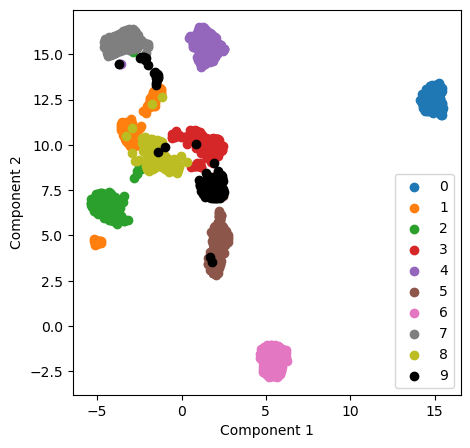

In [41]:
target_ids = range(len(df.target_names))
plt.figure(figsize=(5, 5))
for i, c, label in zip(target_ids, colors, df.target_names):
    plt.scatter(X_umap[y == i, 0], X_umap[y == i, 1], c=c, label=label)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

## Comparing PCA, t-SNE, MDS and UMAP runtimes

In [6]:
def data_size_scaling(algorithm, data, sizes=[100, 200, 400 ,800, 1600], n_runs=6):
    result = []
    for size in sizes:
        for run in range(n_runs):
            subsample = resample(data, n_samples=size)
            start_time = time.time()
            algorithm.fit(subsample)
            elapsed_time = time.time() - start_time
            del subsample
            result.append((size, elapsed_time))
    return pd.DataFrame(result, columns=('dataset size', 'runtime (s)'))

In [7]:
all_algorithms = [
    PCA(),
    UMAP(),
    TSNE(),
    MDS(normalized_stress='auto'),
]
performance_data = {}
for algorithm in all_algorithms:
    
    alg_name = str(algorithm).split('(')[0]
    performance_data[alg_name] = data_size_scaling(algorithm, X, n_runs=5)

    print(f"[{time.asctime(time.localtime())}] Completed {alg_name}")

[Wed Apr  3 10:41:34 2024] Completed PCA


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[Wed Apr  3 10:42:06 2024] Completed UMAP
[Wed Apr  3 10:42:38 2024] Completed TSNE
[Wed Apr  3 10:46:16 2024] Completed MDS


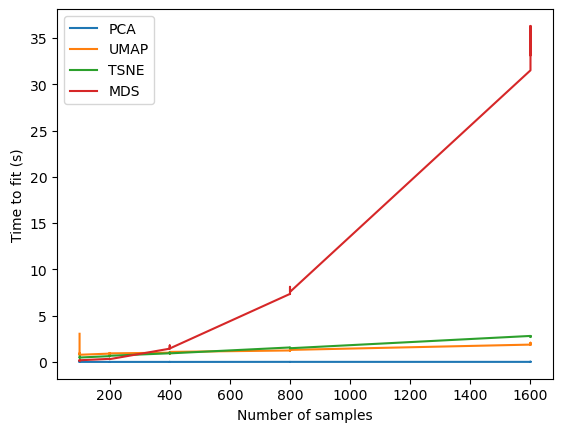

In [8]:
for alg_name, perf_data in performance_data.items():
    # print(perf_data['dataset size'], perf_data['runtime (s)'])
    plt.plot(perf_data['dataset size'], perf_data['runtime (s)'], label=alg_name)
plt.xlabel("Number of samples")
plt.ylabel("Time to fit (s)")
plt.legend()
plt.show()

Interactive plot to visualize UMAP results : https://grantcuster.github.io/umap-explorer/